In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

import holidays

In [2]:
demand_df = pd.read_csv("data/demand_data.csv")
temp_df = pd.read_csv("data/temperature_data.csv")

In [6]:
demand_df.shape

(83664, 2)

# SARIMA

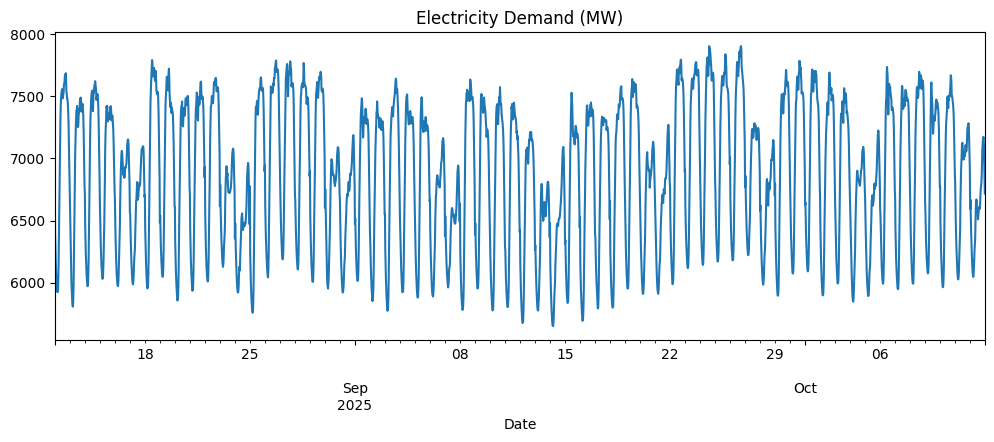

ADF Statistic: -7.280
p-value: 0.000


In [ ]:
# Prepare
demand_df = pd.read_csv("data/demand_data.csv")
demand_df['Date'] = pd.to_datetime(demand_df['Date'])
# Let's just do the previous 2 years
demand_df = demand_df[demand_df["Date"] >= "2025-8-12"]
demand_df = demand_df.set_index('Date').asfreq('30min')
demand_df['Demand'].plot(figsize=(12,4), title='Electricity Demand (MW)')
plt.show()

# Stationarity test
result = adfuller(demand_df['Demand'].dropna())
print(f"ADF Statistic: {result[0]:.3f}")
print(f"p-value: {result[1]:.3f}")

# this means no need for differencing, yay!

In [8]:
demand_df

,Demand
Date,
2025-08-12 00:00:00,6676.6285
2025-08-12 00:30:00,6383.2652
2025-08-12 01:00:00,6258.0791
2025-08-12 01:30:00,6158.7620
2025-08-12 02:00:00,6081.3650
...,...
2025-10-12 21:30:00,7168.8465
2025-10-12 22:00:00,7108.2707
2025-10-12 22:30:00,6973.1767


In [ ]:
"""
From previous EDA done, there is daily seasonality (s = 48)
"""

# Define model
model = SARIMAX(
    demand_df["Demand"],
    order=(1, 1, 1),              # non-seasonal p,d,q
    seasonal_order=(1, 1, 1, 48), # seasonal P,D,Q,s (daily seasonality)
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit
results = model.fit(disp=False)
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                             Demand   No. Observations:                 2976
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 48)   Log Likelihood              -15176.848
Date:                            Sun, 26 Oct 2025   AIC                          30363.696
Time:                                    15:50:51   BIC                          30393.518
Sample:                                08-12-2025   HQIC                         30374.446
                                     - 10-12-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8366      0.025     33.169      0.000       0.787       0.886
ma.L1         -0.7024      0.030   

In [ ]:
"""
“Each half-hour’s demand depends on the last half-hour, and on the demand roughly one day ago 
It also accounts for shocks (errors) that persist for one day.”
"""

## SARIMAX - Weekend Flag

In [9]:
# Prepare
demand_df = pd.read_csv("data/demand_data.csv")
demand_df['Date'] = pd.to_datetime(demand_df['Date'])
demand_df['is_weekend'] = demand_df['Date'].dt.dayofweek.isin([5,6]).astype(int)
# Let's just do the previous 2 months
demand_df = demand_df[demand_df["Date"] >= "2025-8-12"]
demand_df = demand_df.set_index('Date')

In [ ]:
exog_vars = demand_df[["is_weekend"]]

model_2 = SARIMAX(
    demand_df["Demand"],
    exog=exog_vars,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 48),  # daily seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_2 = model_2.fit()

print(results_2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Demand   No. Observations:                 2976
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 48)   Log Likelihood              -15145.483
Date:                            Sun, 26 Oct 2025   AIC                          30302.966
Time:                                    17:31:08   BIC                          30338.753
Sample:                                08-12-2025   HQIC                         30315.866
                                     - 10-12-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_weekend   -99.0864      3.087    -32.101      0.000    -105.136     -93.037
ar.L1          0.8152      0.027   

In [ ]:
# train test splot
split = int(len(demand_df) * 0.9)
train = demand_df.iloc[:split]
test = demand_df.iloc[split:]

# Prepare exogenous variables
exog_train = train[["is_weekend"]]
exog_test = test[["is_weekend"]]

# Fit model on training data
model = SARIMAX(
    train["Demand"],
    exog=exog_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 48),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()

# Forecast for test period
forecast = results.get_forecast(steps=len(test), exog=exog_test)
predictions = forecast.predicted_mean

# Calculate MAPE
mape = mean_absolute_percentage_error(test["Demand"], predictions) * 100
print(f"MAPE: {mape:.2f}%")


c:\Users\rocky\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
c:\Users\rocky\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)


MAPE: 2.24%


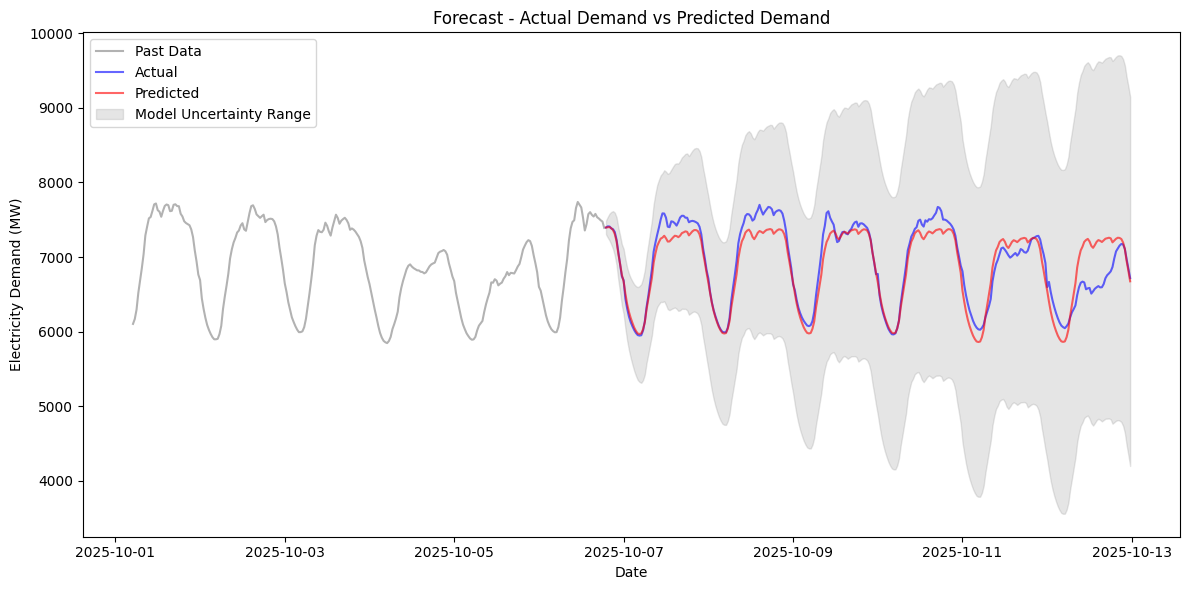

In [ ]:
plt.figure(figsize=(12, 6))

train_visible = train.iloc[int(len(train) * 0.9):]
plt.plot(train_visible.index, train_visible["Demand"], label="Past Data", color="gray", alpha=0.6)
plt.plot(test.index, test["Demand"], label="Actual", color="blue", alpha=0.6)
plt.plot(test.index, forecast.predicted_mean, label="Predicted", color="red", alpha=0.6)

# Confidence interval
plt.fill_between(
    test.index,
    forecast.conf_int()["lower Demand"],
    forecast.conf_int()["upper Demand"],
    color="grey",
    alpha=0.2,
    label="Model Uncertainty Range"
)

plt.xlabel("Date")
plt.ylabel("Electricity Demand (MW)")
plt.title("Forecast - Actual Demand vs Predicted Demand")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

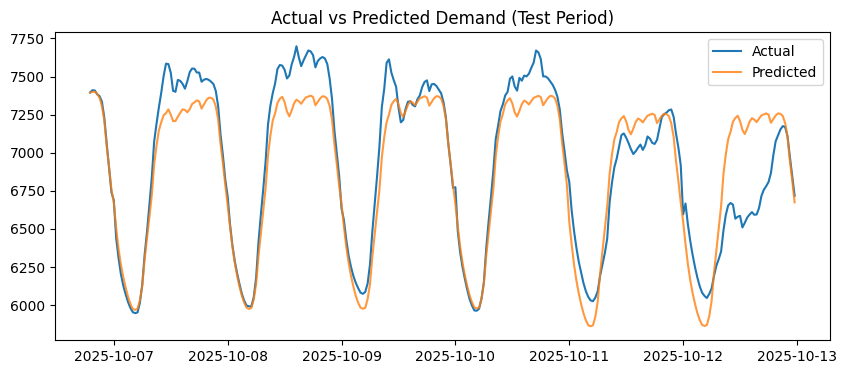

In [23]:
plt.figure(figsize=(10,4))
plt.plot(test.index, test["Demand"], label="Actual")
plt.plot(test.index, predictions, label="Predicted", alpha=0.8)
plt.legend()
plt.title("Actual vs Predicted Demand (Test Period)")
plt.show()


# Regression

In [3]:
demand_df = pd.read_csv("data/demand_data.csv")
temp_df = pd.read_csv("data/temperature_data.csv")
gdp_df = pd.read_csv("data/gdp_data.csv")

ev_df = pd.DataFrame({
    "Year": [2021, 2022, 2023, 2024, 2025],
    "EV Count": [2942, 6531, 11941, 26225, 38666]
})

In [4]:
df = temp_df.merge(demand_df, how="left", on=["Date"]).merge(gdp_df, how="left", on=["Date"])
df = df.fillna(0)
df = df.drop_duplicates(subset = "Date")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by="Date").reset_index(drop=True)

In [ ]:
df = demand_df.copy()
df['Hour'] = df['Date'].dt.hour
df['DayOfWeek'] = df['Date'].dt.dayofweek   
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['DateOnly'] = df['Date'].dt.date

# sg holidays
years = df['Date'].dt.year.unique()
sg_holidays = holidays.Singapore(years=years)

# Holiday flag
df['IsHoliday'] = df['DateOnly'].isin(sg_holidays).astype(int)
# Weekend flag
df['IsWeekend'] = df['Date'].dt.dayofweek.isin([5,6]).astype(int)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24) # according to plot, follows -sin wave
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12) # according to plot, follow -cos wave

In [87]:
df.columns

Index(['Date', 'Temperature', 'Demand', 'GDP Growth', 'Hour', 'DayOfWeek',
       'Month', 'Year', 'DateOnly', 'IsHoliday', 'IsWeekend', 'Hour_sin',
       'Month_cos'],
      dtype='object')

In [93]:
# Predictors and target
X = df[['Temperature', 'GDP Growth', 'IsWeekend', 'IsHoliday', 'Hour_sin', 'Month_cos']]
y = df['Demand']

# Train-test split (80%-20%)
split_index = int(len(df) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Fit regression
reg = LinearRegression()
reg.fit(X_train, y_train)

# Predict on test set
y_pred = reg.predict(X_test)

# Compute metrics
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f} MW")


MAPE: 5.28%
RMSE: 467.90 MW


In [6]:
# Predictors and target
X = df[['Temperature', 'GDP Growth', 'IsWeekend', 'IsHoliday', 'Hour_sin', 'Month_cos']]
y = df['Demand']

# Train-test split (80%-20%)
split_index = int(len(df) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Add constant for intercept
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit regression using statsmodels
model = sm.OLS(y_train, X_train_const).fit()

# Print full summary (includes p-values)
print(model.summary())

# Predict on test set
y_pred = model.predict(X_test_const)

# Compute metrics
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nMAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f} MW")


                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     7908.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:55:08   Log-Likelihood:            -2.8786e+05
No. Observations:               38438   AIC:                         5.757e+05
Df Residuals:                   38431   BIC:                         5.758e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2734.7890     65.282     41.892      